# Quantifying Convergence and Acommodation in Political Twitter

The following is a complete breakdown of the quantitative methods outlined in the paper: "A BERT's eye view"

#### BERT Embeddings
So before I begin with the model formalism, let’s set up some variables. Let’s assume that I have a language transformer model BERT that can take as an input any sentence x and return a set of word vectors for every word in that sentence, Ex. Because BERT composes word vectors based on context, we only need the word vector for a keyword w′ whose variation in context across utterances/sentences we are interested in studying (think: how people use the word “immigration” across a variety of utterances), because it will contain all the requisite information we need about the linguistic context surrounding it. In equation 1, let $[\![w′]\!]$ be a function that returns only the word vector for a word w in sentence x if it matches the keyword w′ whose usage and context we are interested in studying.

$$ E_{x,w'} = BERT(x)[\![w']\!] $$

As an example, let’s say we have an utterance in the form of a tweet x–“We need to fix our broken immigration system! #noborderwall”. We’re interested in studying how some population of Twitter users use the word (w′) “immigration” in context, so we convert all the tokens in the tweet to word vectors Ex first. Because we’re interested in similarities and differences in the context surrounding the word “immigration” across tweets, and because BERT vectors explicitly contain information about the linguistic context of a word in the vector it generates for it, we only need to take the word vector for the token whose context we’re interested in studying–Ex,w′ , or the word vector for the word “immigration”.

Example code to implement this is shown below. The complete script to accomplish this using the data described in the paper is in the script allGovVecs.py and it calls to the function BERT.py or BERT_gpu.py

In [ ]:
import pandas as pd
import numpy as np

# If on the remote server
from mod.BERT_gpu import *

level = 7
mod = embeds(device='cuda')
output_marker ='-sum'+str(level)


W_ = ['immigration', 'immigrants', 'wall', 'border', 'mexico']

################################################################
### Political corpus
################################################################
PATH = '/home/zaq/d/poli/'
output_name = '538vecs'+output_marker+'.csv'
dataset = 'corpora/538senators.csv'


df = pd.read_csv(PATH + dataset, encoding='ISO-8859-1')
print('pre-dropping of duplicates', len(df))
df['text'] = [str(entry).split('http')[0] for entry in df['text'].values]
df = df.loc[df['text'].isin([text for text in df['text'].values if sum([wi in str(text).lower() for wi in W_]) > 0])]
df = df.drop_duplicates(subset=['text'])
# df.index=range(len(df))

print(list(df))
print(W_)
print(PATH+dataset, len(df), '\n')

#(1) Set up .csv file for data repo
data = pd.DataFrame(columns=['party', 'user', 'date', 'w', 'vec', 'text'])
data.to_csv(PATH+output_name, index=False, encoding='utf-8')

#(2) Generate embeddings with appropriate metadata
for k in df.index:
    p, u, text, d = df[['party', 'user', 'text', 'created_at']].loc[k]
    #print(text, '\n')
    if sum([wi in text.lower() for wi in W_]) > 0:
        for w in W_:
            try:
                vecs = mod(w, str(text).lower(), level=level)
                update = [[p, u, d, w, str(vec.view(-1).cpu().tolist()), k] for vec in vecs]
                update = pd.DataFrame(np.array(update), columns=list(data))
                update.to_csv(PATH + output_name, index=False, encoding='utf-8', header=False, mode='a')
            except ValueError:
                0
            except IndexError:
                0
            except RuntimeError:
                0

Rather than implementing this from scratch, I imported pre-generated the vectors for the study and then imported them later via the following.

In [1]:
import glob, os
from shared.mod.sim_matrix import *
session_path = "/Volumes/V'GER/comp_ling/DataScideProjects/GovComm/data/mid/lvl7-large"
fils = np.sort(glob.glob(os.path.join(session_path, '*-lvl7.csv')))
dfU = [pd.read_csv(f) for f in fils if 'BLM' not in f]

#Setting date-time to be standard date-time format
dfU[0]['date'] = pd.to_datetime(dfU[0]['date'])
add_year = np.array([len(i.split()) < 3 for i in dfU[1]['date'].values])
dfU[1]['date'].loc[add_year] = dfU[1]['date'].loc[add_year] + ' 2016'
dfU[1]['date'] = pd.to_datetime(dfU[1]['date'])
dfU[2]['date'] = [i.replace('_', ' ') for i in dfU[2]['date']]
dfU[2]['date'] = pd.to_datetime(dfU[2]['date'], yearfirst=True)
dfU[3]['date'] = pd.to_datetime(dfU[3]['date'], yearfirst=True)

dfU = pd.concat(dfU, ignore_index=True)
dfU = dfU.loc[dfU['date'].values >= np.datetime64('2015-01-01')]

dfU['line.no'] = dfU['text'].values
dfU = dfU.sort_values(by=['date'])
dfU.index=range(len(dfU))


####################################################################################################
#### Vectors
####################################################################################################
Eu = torch.FloatTensor([[np.float(n) for n in vec.replace('[','').replace(']','').split(', ')] for vec in dfU['vec'].values])

####################################################################################################
#### Selection Spans
####################################################################################################
OBA = dfU['party'].isin(['OBA']).values
TRM = dfU['party'].isin(['TRM']).values
HRC = dfU['party'].isin(['HRC']).values
BERN = dfU['user'].isin(['SenSanders']).values
CRUZ = dfU['user'].isin(['SenTedCruz']).values
OTRA = (~dfU['party'].isin(['OBA', 'TRM', 'HRC']) & ~dfU['user'].isin(['SenSanders', 'SenTedCruz'])).values

####################################################################################################
#### Selection Spans - Limiting Individuals
####################################################################################################
DEM = dfU['party'].isin(['D']).values
GOP = dfU['party'].isin(['R']).values
OBA = OBA & (dfU['date'].values <= dfU['date'].values[OTRA].max())
HRC = HRC & (dfU['date'].values <= dfU['date'].values[OTRA].max())
TRM = TRM & (dfU['date'].values <= dfU['date'].values[OTRA].max())
BERN = BERN & (dfU['date'].values <= dfU['date'].values[OTRA].max())
CRUZ = CRUZ & (dfU['date'].values <= dfU['date'].values[OTRA].max())


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Probability Calculations
Now, we need to compare the word vector generated from a tweet/sentence Ex,w′ to the word vector for another key word, in a second tweet/sentence, Ey,w′ . We get a raw comparison score by taking the Cosine Error (CoE) of the word vectors Ex,w′ and Ey,w′ . I use CoE here because, usefully, if the two word vectors are exactly the same, which can only occur if they are for the same word in identical contexts, CoE will equal zero. Greater differences in context will lead to higher CoE values. This allows us to quantify raw similarity and dissimilarity.

This isn’t sufficient however. CoE is continuous from 0 to 1, and that unconditioned continuity leads to noisy data as well as difficulty in interpreting similarity scores. We need a way to quantify our belief that a given raw CoE score captures similarity in a way that humans might perceive as significant. To quantify this sort of judgement I use a half-Gaussian distribution with a range from $[0, \infty]$, where $\mu = 0$ (so that when CoE is zero we have maximum confidence that contexts are similar between tweets), and a scale value $\sigma$ that can be set either via simple parameter estimation methods, or manually based on trial and error. The scale value $\sigma$ is crucial, as it sets the slope of the distribution, and thus represents a penalty on high CoE values–smaller values for σ translate to higher penalties for CoE values farther away from 0. This logic is formalized in equation 2.

$$ P(E_{x,w'}|E_{y,w'}) = P_{\mathcal{N}_{[0,\infty]}} \left( CoE(E_{x,w'},E_{y,w'}) \bigg| \mu=0, \sigma \right) $$

#### Similarity Matrix
We can use equation 2 to construct a similarity matrix MX;Y where every cell in the matrix is a comparison between the xth and yth tweets in the same data set.

$$ \mathbb{M}^{X,Y} = \lbrace (x;y): P(E_{x,w'}|E_{y,w'})  \rbrace $$

In [2]:
Pi = probFn(.05)
M = Pi.streamPROB(Eu,Eu)
M = M/Pi.p(torch.FloatTensor([0]))

#Remove comparison to same tweet for analysis.
M = M * (torch.eye(M.shape[0]) == 0).float()

### Language Convergence/Cohesion
How can one measure language convergence using the similarity matrix MX;Y ? Let’s assume that language convergence is marked by groups sounding more similar within their group than they do to those who are outside of their group. When we make this assumption, we can metricize language convergence by comparing the mean similarity of utterances made by members of some group g to other members of their same group (i.e. $x \in g$ and $y \in g$), to how similar members of a group are to individuals outside of their group ($x \in g$ and $y \notin g$) using MX;Y . This simple comparison yields equation 4.

$$ \frac{\frac{1}{N} \mathbb{M}^{X,Y}(x \in g; y \in g) } {\frac{1}{N} \mathbb{M}^{X,Y}(x \in g; y \notin g) } $$

The result is an easily interpretable metric, where scores larger than 1 indicate high language convergence within a group, and scores less than 1 indicate high language divergence between group members.

## Accommodation
Measuring language accommodation is a little trickier. Let’s assume for a second that we have a simple case in which we have three utterances–utterance A, utterance B, and utterance C–arranged and labeled according to the order in which they were written/spoken (i.e. A was written/spoken first, and C was written/spoken last). If we want to to prove that the language used in utterance C shows signs of accommodating to the language used in utterance A we need to show that (1) the representation for utterance C is most similar to utterance A, when compared to any other tweet (in this case, just utterance B). Simultaneously we need to (2) make sure that it is the case that the detected similarity is not due to utterance C being uniformly similar (or dissimilar for that matter) to any previous tweet. To satisfy both of these constraints, we can divide the similarity of utterance A and utterance C by the summed similarity of all utterances written/spoken before C, and then divide this by 1/the total number of tweets preceding utterance C (or, simply multiplying everything by the number of utterances preceding utterance C which is mathematically the same). Equation 5 formalizes these constraints. Let Z be the set of all utterances written/spoken before utterance y, including utterance x.

$$ \mathbb{A}^{X,Y} = \Bigg\lbrace (x,y): (N_{\mathcal{Z}}) \frac{\mathbb{M}^{X,Y}(x,y)}{\sum_\mathcal{Z} \mathbb{M}^{X,Y}(\mathcal{Z},y)} \Bigg\rbrace $$

This yields a value greater than 1 if there is positive evidence in favor of accommodation (i.e. the described constraints are all met). It yields a value of 1 if there is uniform similarity of all prior utterances to utterance C. And it yields a value less than 1 if utterance C positively accommodates a separate tweet as opposed to utterance A.

The code to implement this is shown below.

In [3]:
def accommodation(M):

    I0 = torch.eye(M.shape[0])
    for i in I0.nonzero():
        I0[i[0], i[1]:] = 1

    xout = (torch.eye(M.shape[0]) == 0).float()

    return ((M * I0 * xout) / (M * I0).sum(dim=0).unsqueeze(0)).nan_to_num() * I0.sum(dim=0).unsqueeze(0)


M0 = accommodation(M)

### Monte Carlo Permutation Test Procedure and Results (Section 3.2.1)

An important question is how should we test the significance of convergence and accommodation scores? One way to test the significance of our results is to compare them to a simulated “null” distribution–that is, a simulated distribution that captures the constraints of the null hypothesis– via a Monte Carlo Permutation Test Procedure (MCPTP). For both language convergence and accommodation, our null hypotheses (H1.0 and H2.0) are that group affiliation has no effect on corresponding scores. We can generate a distribution that captures what it would look like if this were the case for each of these null hypotheses by randomly permuting the political party labels for our senators, calculating a convergence or accommodation score using the randomly permuted data, and then repeating until we can generate a Gaussian distribution from some predetermined number of N random permutations. From this simulated null distribution we can generate credible intervals (CI) for our null hypotheses, as well as generate a p-value for true convergence or accom- modation scores by taking the probability of the true score conditioned on its corresponding null distribution. Low probabilities for true scores given their corresponding null distribution indicate that the scores reported cannot be accounted for by any arbitrary grouping of individuals, but can be/is accounted for by splitting the data up by politicians’ actual party affiliations.

##### Convergence

In [ ]:
people = {'Democrats':{'in':DEM, 'out':GOP, 'per':DEM, 'indic':'D'}, 'GOP':{'in':GOP, 'out':DEM, 'per':GOP, 'indic':'R'}, 'Barack Obama':{'in':DEM, 'out':GOP, 'per':OBA, 'indic':'D'}, 'Hillary Clinton':{'in':DEM, 'out':GOP, 'per':HRC, 'indic':'D'}, 'Bernie Sanders':{'in':DEM, 'out':GOP, 'per':BERN, 'indic':'D'}, 'Donald Trump':{'in':GOP, 'out':DEM, 'per':TRM, 'indic':'R'}, 'Ted Cruz':{'in':GOP, 'out':DEM, 'per':CRUZ, 'indic':'R'}}

data_points = []
for k,points in people.items():
    ingroup, outgroup, person = points['in'], points['out'], points['per']
    check = (M[person][:, ingroup].mean()/M[person][:, outgroup].mean()).nan_to_num()
    x__ = []
    for i in range(100):
        sublabels = np.concatenate([ingroup.nonzero()[0], outgroup.nonzero()[0]])
        in_group = np.sort(np.random.choice(sublabels, size=(ingroup.sum(),), replace=False))
        out_group = np.array([idx for idx in sublabels if idx not in in_group])
        x = M[person][:, in_group].mean()/M[person][:, out_group].mean()
        x__ += [x.nan_to_num().view(-1)]
    x__ = torch.cat(x__, dim=-1).nan_to_num()
    data_points += [[k, points['indic'], l.item(), check.item()] for l in x__.view(-1)]
data_points = pd.DataFrame(np.array(data_points), columns=['politician', 'party', 'noise.score', 'true.score'])
data_points['noise.score'] = data_points['noise.score'].astype(float)
data_points['true.score'] = data_points['true.score'].astype(float)

#Create a dataframe of converegence scores, null distribution, etc.
dfp = []
for poli in data_points['politician'].unique():
    noise_mu, noise_sigma = data_points['noise.score'].loc[data_points['politician'].isin([poli])].mean(), data_points['noise.score'].loc[data_points['politician'].isin([poli])].std()
    true_mu = data_points['true.score'].loc[data_points['politician'].isin([poli])].unique()[0]
    ci = [np.around(noise_mu-(2*noise_sigma),2), np.around(noise_mu+(2*noise_sigma),2)]
    prob = torch.distributions.Normal(noise_mu, noise_sigma)
    dfp.append([poli, np.around(noise_mu,2), np.around(noise_sigma,2), ci, np.around(true_mu,2), np.around(torch.exp(prob.log_prob(torch.FloatTensor([true_mu]))).item(),2)])

dfp = pd.DataFrame(np.array(dfp), columns=['politician', 'noise.mu', 'noise.s', 'ci', 'true.mu', 'P(true.mu|Noise)'])
dfp.to_csv("/Volumes/V'GER/comp_ling/DataScideProjects/GovComm/methods/BEST/analyses/hyp_convergence.csv", index=False, encoding='utf-8')

##### Accommodation

In [ ]:
people = {'Barack Obama':{'in':DEM, 'out':GOP, 'per':OBA, 'indic':'D'}, 'Hillary Clinton':{'in':DEM, 'out':GOP, 'per':HRC, 'indic':'D'}, 'Bernie Sanders':{'in':DEM, 'out':GOP, 'per':BERN, 'indic':'D'}, 'Donald Trump':{'in':GOP, 'out':DEM, 'per':TRM, 'indic':'R'}, 'Ted Cruz':{'in':GOP, 'out':DEM, 'per':CRUZ, 'indic':'R'}}

data_points = []
for k,points in people.items():

    ingroup, outgroup, person = points['in'], points['out'], points['per']

    x = M0[person][:, ingroup]

    check = (x.sum(dim=-1) / torch.FloatTensor([len(x[k].nonzero()) for k in range(len(x))])).nan_to_num().view(-1)

    x__ = []
    for i in range(100):
        sublabels = np.concatenate([ingroup.nonzero()[0], outgroup.nonzero()[0]])
        sublabels = np.sort(np.random.choice(sublabels, size=(ingroup.sum(),), replace=False))

        x = M0[person][:, sublabels]
        x = (x.sum(dim=-1) / torch.FloatTensor([len(x[k].nonzero()) for k in range(len(x))])).nan_to_num().view(-1)
        x__ += [x.mean().view(-1)]

    x__ = torch.cat(x__, dim=-1)
    data_points += [[k, points['indic'], l.item(), check.mean().item()] for l in x__.view(-1)]

data_points = pd.DataFrame(np.array(data_points), columns=['politician', 'party', 'noise.score', 'true.score'])
data_points['noise.score'] = data_points['noise.score'].astype(float)
data_points['true.score'] = data_points['true.score'].astype(float)

#Create a dataframe of accommodation scores, null distribution, etc.
dfp = []
for poli in data_points['politician'].unique():
    noise_mu, noise_sigma = data_points['noise.score'].loc[data_points['politician'].isin([poli])].mean(), data_points['noise.score'].loc[data_points['politician'].isin([poli])].std()
    true_mu = data_points['true.score'].loc[data_points['politician'].isin([poli])].unique()[0]
    ci = [np.around(noise_mu-(2*noise_sigma),2), np.around(noise_mu+(2*noise_sigma),2)]
    prob = torch.distributions.Normal(noise_mu, noise_sigma)
    dfp.append([poli, np.around(noise_mu,2), np.around(noise_sigma,2), ci, np.around(true_mu,2), np.around(torch.exp(prob.log_prob(torch.FloatTensor([true_mu]))).item(),2)])
    # dfp.append([poli, np.around(noise_mu,2), np.around(noise_sigma,2), ci, np.around(true_mu,2), np.around(prob.cdf(torch.FloatTensor([true_mu])).item(),2)])
dfp = pd.DataFrame(np.array(dfp), columns=['politician', 'noise.mu', 'noise.s', 'ci', 'true.mu', 'P(true.mu|Noise)'])
dfp.to_csv("/Volumes/V'GER/comp_ling/DataScideProjects/GovComm/methods/BEST/analyses/hyp_accommodation.csv", index=False, encoding='utf-8')



### Monte Carlo Bootstrapping Procedure (Section 3.2.2)

In a couple of exploratory cases it was particularly interesting to test whether values for con- vergence and accommodation were significantly different from one another. For example, if Barack Obama scores 5 for accommodation ($A^{X;Y} (Obama) = 5$) and Hillary Clinton scores 4.75 ($A^{X;Y}(Clinton) = 4.75$) are these scores significantly different from one another? To test this, I randomly sampled $N$ sub-populations, consisting of a subset of $k$ of Senators, without randomly permuting their party affiliations. I can then calculate the test statistic from this sub-sample. After N random samples, we can calculate a Gaussian distribution for the test statistic where $\mu$ is the mean of all test statistics calculated from sub-samples, and $\sigma$ is the standard deviation for all the test statistics calculated from the sub-samples. We can use these distributions then to compare whether or not two scores for convergence or accommodation are significantly different from one another via a plethora of procedures. Going back to the example, this is the same as randomly sampling a sub-population of Democratic senators, using that sub-population to calculate a new test statistic for accommodation for Barack Obama and Hillary Clinton, and then using those collections of test statistic samples to see whether or not there is a significant difference in the distributions of those accommodation scores from the randomly sampled Democratic senators for the two.

#### Convergence

In [4]:
nsamples = 1000
sample_size = 100

people = {'Senate Democrats': {'in': DEM, 'out': GOP, 'per': DEM, 'indic': 'D'},
          'Senate GOP': {'in': GOP, 'out': DEM, 'per': GOP, 'indic': 'R'},
          'Barack Obama': {'in': DEM, 'out': GOP, 'per': OBA, 'indic': 'D'},
          'Hillary Clinton': {'in': DEM, 'out': GOP, 'per': HRC, 'indic': 'D'},
          # 'Bernie Sanders': {'in': DEM, 'out': GOP, 'per': BERN, 'indic': 'D'},
          'Donald Trump': {'in': GOP, 'out': DEM, 'per': TRM, 'indic': 'R'},
          'Ted Cruz': {'in': GOP, 'out': DEM, 'per': CRUZ, 'indic': 'R'}}

data_points = []
for k, points in people.items():
    ingroup, outgroup, person = points['in'], points['out'], points['per']
    in_l, out_l = np.concatenate([np.random.choice(ingroup.nonzero()[0], size=(sample_size,), replace=False).reshape(1,-1) for _ in range(nsamples)], axis=0), np.concatenate([np.random.choice(outgroup.nonzero()[0], size=(sample_size,), replace=False).reshape(1,-1) for _ in range(nsamples)], axis=0)
    vals = [(M[person][:,m].mean()/M[person][:,n].mean()) for m,n in list(zip(in_l, out_l))]
    data_points+=[[k, points['indic'], val.item()] for val in vals]
    print(k, 'completed')
data_points = pd.DataFrame(np.array(data_points), columns=['politician', 'party', 'score'])
data_points.score = data_points.score.astype(float)

#Ttest results
from scipy.stats import ttest_ind as ttest
ttest_table = []
for cond in [['Senate Democrats', 'Senate GOP'], ['Barack Obama', 'Hillary Clinton'], ['Ted Cruz', 'Donald Trump'], ['Hillary Clinton', 'Donald Trump']]:
    res = ttest(data_points['score'].loc[data_points['politician'].isin([cond[0]])].astype(float).values, data_points['score'].loc[data_points['politician'].isin([cond[1]])].astype(float).values)
    ttest_table+= [['{} vs. {}'.format(*cond), res.statistic, res.pvalue]]
ttest_table = pd.DataFrame(np.array(ttest_table), columns=['condition', 't({})'.format(sample_size*2-2), 'p'])
ttest_table.to_csv("/Volumes/V'GER/comp_ling/DataScideProjects/GovComm/methods/BEST/analyses/ttest_convergence.csv", index=False, encoding='utf-8')

#Distributions
d_table = []
for poli in ['Senate Democrats', 'Senate GOP', 'Barack Obama', 'Hillary Clinton', 'Donald Trump', 'Ted Cruz']:
    d = data_points['score'].loc[data_points['politician'].isin([poli])].astype(float).values
    d_table += [[poli, d.mean(), d.std(), '[{},{}]'.format(d.mean()-(2*d.std()), d.mean()+(2*d.std()))]]
d_table = pd.DataFrame(np.array(d_table), columns=['Politician', 'mu', 'std', '95% CI'])
d_table.to_csv("/Volumes/V'GER/comp_ling/DataScideProjects/GovComm/methods/BEST/analyses/dist_convergence.csv", index=False, encoding='utf-8')

Senate Democrats completed
Senate GOP completed
Barack Obama completed
Hillary Clinton completed
Donald Trump completed
Ted Cruz completed


Plotting scores (Democrats vs. Republicans)

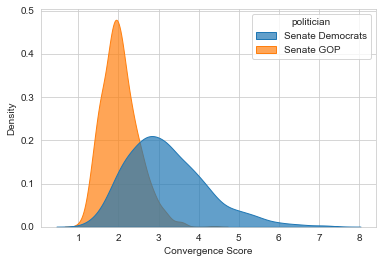

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style='whitegrid')

sns.kdeplot(data=data_points.loc[data_points['politician'].isin(['Senate Democrats', 'Senate GOP'])], x='score', hue='politician', alpha=.7, fill=True)
plt.xlabel('Convergence Score')
plt.savefig("/Volumes/V'GER/comp_ling/DataScideProjects/GovComm/methods/BEST/analyses/dem_gop-convergence.png")
plt.show()

#### Accommodation

In [11]:
nsamples = 1000
sample_size = 100

people = {#'Senate Democrats': {'in': DEM, 'out': GOP, 'per': DEM, 'indic': 'D'},
          #'Senate GOP': {'in': GOP, 'out': DEM, 'per': GOP, 'indic': 'R'},
          'Barack Obama': {'in': DEM, 'out': GOP, 'per': OBA, 'indic': 'D'},
          'Hillary Clinton': {'in': DEM, 'out': GOP, 'per': HRC, 'indic': 'D'},
          # 'Bernie Sanders': {'in': DEM, 'out': GOP, 'per': BERN, 'indic': 'D'},
          'Donald Trump': {'in': GOP, 'out': DEM, 'per': TRM, 'indic': 'R'},
          'Ted Cruz': {'in': GOP, 'out': DEM, 'per': CRUZ, 'indic': 'R'}}

data_points = []
for k, points in people.items():
    ingroup, outgroup, person = points['in'], points['out'], points['per']
    in_l = np.concatenate([np.random.choice(ingroup.nonzero()[0], size=(sample_size,), replace=False).reshape(1,-1) for _ in range(nsamples)], axis=0)
    x = [M0[person][:,m] for m in in_l]
    x = [(xi.sum(dim=-1)/torch.FloatTensor([len(xi[k].nonzero()) for k in range(len(xi))])).nan_to_num().mean().view(-1) for xi in x]
    vals = torch.cat(x, dim=-1)
    data_points+=[[k, points['indic'], val.item()] for val in vals]
    print(k, 'completed')
data_points = pd.DataFrame(data_points, columns=['politician', 'party', 'score'])
data_points.score = data_points.score.astype(float)

#Ttest results
from scipy.stats import ttest_ind as ttest
ttest_table = []
for cond in [['Barack Obama', 'Hillary Clinton'], ['Ted Cruz', 'Donald Trump'], ['Hillary Clinton', 'Donald Trump']]:
    res = ttest(data_points['score'].loc[data_points['politician'].isin([cond[0]])].values, data_points['score'].loc[data_points['politician'].isin([cond[1]])].values)
    ttest_table+= [['{} vs. {}'.format(*cond), res.statistic, res.pvalue]]
ttest_table = pd.DataFrame(np.array(ttest_table), columns=['condition', 't({})'.format(sample_size*2-2), 'p'])
ttest_table.to_csv("/Volumes/V'GER/comp_ling/DataScideProjects/GovComm/methods/BEST/analyses/ttest_accommodation.csv", index=False, encoding='utf-8')

#Distributions
d_table = []
for poli in ['Barack Obama', 'Hillary Clinton', 'Donald Trump', 'Ted Cruz']:
    d = data_points['score'].loc[data_points['politician'].isin([poli])].values
    d_table += [[poli, d.mean(), d.std(), '[{},{}]'.format(d.mean()-(2*d.std()), d.mean()+(2*d.std()))]]
d_table = pd.DataFrame(np.array(d_table), columns=['Politician', 'mu', 'std', '95% CI'])
d_table.to_csv("/Volumes/V'GER/comp_ling/DataScideProjects/GovComm/methods/BEST/analyses/dist_accommodation.csv", index=False, encoding='utf-8')

Barack Obama completed
Hillary Clinton completed
Donald Trump completed
Ted Cruz completed


Ridgeplot of accommodation scores

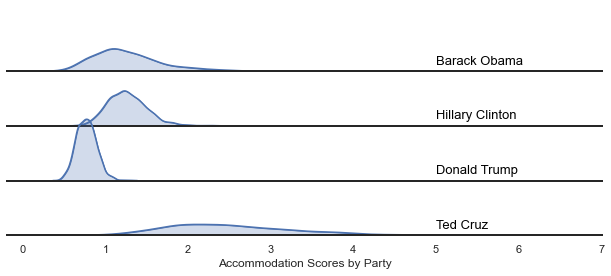

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

g = sns.FacetGrid(data_points, row="politician", aspect=9, height=1)
g.map_dataframe(sns.kdeplot,x="score", hue="party", fill=True)

g.map_dataframe(sns.kdeplot, x="score", hue="party", color='white')

g.fig.subplots_adjust(hspace=-.15)

for title, a in list(zip(data_points['politician'].unique(),g.axes)):
    a[0].text(5, .5, title, color='black', fontsize=13,
            ha="left", va="center")

g.set_titles("")
g.set(yticks=[], xlabel="Accommodation Scores by Party")
g.despine( left=True)
plt.savefig("/Volumes/V'GER/comp_ling/DataScideProjects/GovComm/methods/BEST/analyses/poli-accommodation.png")
plt.show()